# Rosenbrock error function and distribution

This example notebook introduces an optimisation problem and associated toy distribution based on the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), which, in PINTS, we define as:

\begin{equation}
f(x,y) = (1 - x)^2 + 100(y - x^2)^2.
\end{equation}

The function has a global minimum at $(x,y)=(1,1)$. Finding this point is the goal of optimisation algorithms.

We first attempt to find this point using the [XNES optimiser](../optimisation/xnes.ipynb). To do so, we create a method that wraps the `OptimisationController` object since we will be running optimisations from a number of starting points.

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import pints.plot

def run_optimiser(x0, score):
    opt = pints.OptimisationController(score, x0, method=pints.XNES)
    opt.set_log_to_screen(False)
    x1, f1 = opt.run()
    return x1, f1

We then set up the optimisation problem.

In [2]:
# Create Rosenbrock error
score = pints.toy.RosenbrockError()

# Create boundaries
boundaries = pints.RectangularBoundaries([0, 0], [10, 10])

To reduce the risk of reaching a local opposed to global optimum, we use 10 random starting points. PINTS' `sample_initial_points` function does this by sampling uniformly within the supplied boundaries.

In [3]:
x0s = pints.sample_initial_points(function=score, n_points=10, boundaries=boundaries)

Now running the optimisations and storing the results from each starting point.

In [4]:
solns = []
fvals = []
for x0 in x0s:
    x, f = run_optimiser(x0, score)
    solns.append(x)
    fvals.append(f)

We plot the minima found by `XNES` in orange; the true minimum, we show as a blue cross. It is evident that, whilst some solutions found are reasonable, many have not converged to the correct solution. This illustrates the importance of running optimisation routines multiple times.

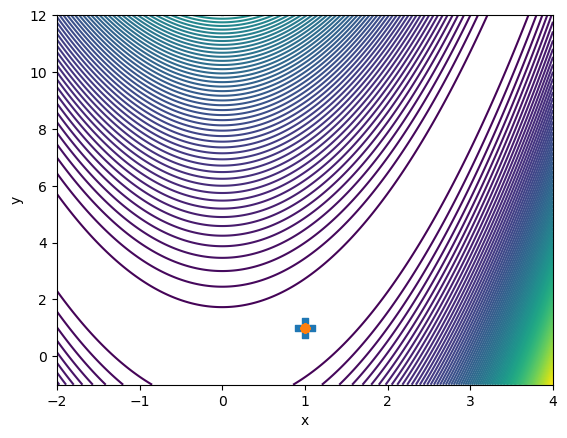

In [5]:
solns_stacked = np.vstack(solns)
true_minimum = np.array([[1, 1]])

# Plot
x = np.linspace(-2, 4, 400)
y = np.linspace(-1, 12, 400)
X, Y = np.meshgrid(x, y)
Z = [[score([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels=100)
plt.scatter(true_minimum[:, 0], true_minimum[:, 1], marker="P", s=200)
plt.scatter(solns_stacked[:, 0], solns_stacked[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Rosenbrock toy distribution

We convert the error function into a distribution for benchmarking samplers. To do so, we use the following transformation:

$ p(x, y) \propto  \frac{1}{1 + \text{RosenbrockError}(x,y)}, $

that is,

$ p(x, y) \propto  \frac{1}{\left(1 + (1 - x)^2 + 100 (y - x^2)^2) \right)}, $

which we term the `RosenbrockLogPDF`.

We can use Hamiltonian Monte Carlo to sample from the posterior distribution.

In [6]:
log_pdf = pints.toy.RosenbrockLogPDF()

# Choose initial points by sampling from a uniform distribution very near the solution
nchains = 4
starting_distribution = pints.UniformLogPrior(
    [0.99, 0.99], [1.01, 1.01]
)
x0s = pints.sample_initial_points(function=log_pdf, n_points=nchains,
                                  random_sampler=starting_distribution.sample)

# Create MCMC controller
mcmc = pints.MCMCController(log_pdf, nchains, x0s, method=pints.HamiltonianMCMC)

# Stop after 4000 iterations
mcmc.set_max_iterations(4000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = np.asarray([chain[2000:] for chain in chains])

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['mean_x', 'mean_y'])
print(results)

Running...
Done!
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
mean_x   0.78    0.47    -0.38   0.54   0.85   1.16   1.46     2.92    21.20  3.85
mean_y   0.81    0.60    -0.18   0.36   0.74   1.31   1.96     3.15    22.66  4.12


We inspect the results by creating a scatter plot of the samples. Hamiltonian Monte Carlo struggles to sample from the thin tails.

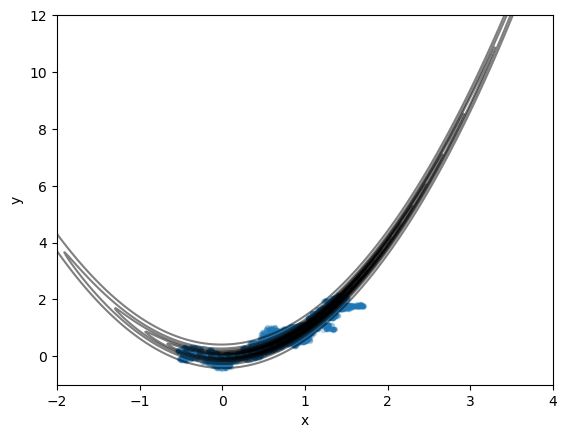

In [7]:
levels = np.linspace(0, 1, 20)
x = np.linspace(-2, 4, 400)
y = np.linspace(-1, 12, 400)
X, Y = np.meshgrid(x, y)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])

stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-2, 4)
plt.ylim(-1, 12)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

This is most evident when plotting the path of one of the chains.

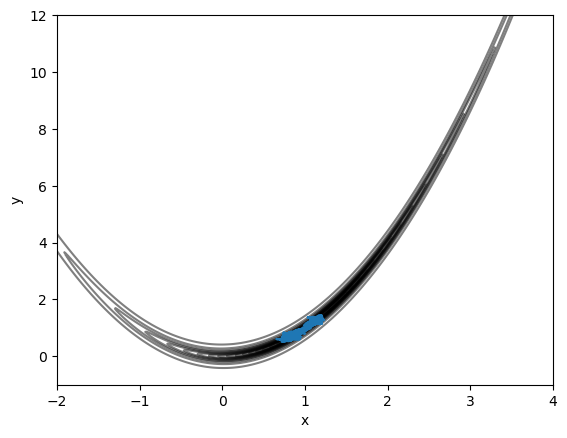

In [8]:
chain = chains[0]

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.plot(chain[0:1000,0], chain[0:1000,1])
plt.xlim(-2, 4)
plt.ylim(-1, 12)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Calculate normed distance of sample mean and sample covariance from true values

In [9]:
print('Normed distance = ' + str(log_pdf.distance(stacked)))

Normed distance = 10.791030644266204
